In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [31]:
# Load the data
df_signals_2016 = pd.read_csv('wind-farm-signals-2016.csv', sep=';')
df_signals_2017 = pd.read_csv('wind-farm-signals-2017.csv', sep=';')

In [32]:
# Merge dataframes
frames = [df_signals_2016, df_signals_2017]
df = pd.concat(frames, ignore_index=True)

In [33]:
# Select turbine
turbine = 'T07'
df = df.loc[df['Turbine_ID'] == turbine]

In [34]:
variables = {
    1: 'Turbine_ID', 
    2: 'Timestamp',
    3: 'Gen_RPM_Avg', 
    4: 'Gen_Bear_Temp_Avg',
    5: 'Gen_Bear2_Temp_Avg',
    6: 'Grd_Prod_Pwr_Avg', 
    7: 'Grd_Prod_PsblePwr_Avg',
    8: 'Rtr_RPM_Avg',
    9: 'Hyd_Oil_Temp_Avg',
    10: 'Gear_Oil_Temp_Avg',
    11: 'Gear_Bear_Temp_Avg',
    12: 'Nac_Temp_Avg',
    13: 'Amb_WindSpeed_Avg',
    14: 'Amb_WindDir_Abs_Avg',
    15: 'Amb_Temp_Avg',
    16: 'Cont_Top_Temp_Avg',
    17: 'Cont_Hub_Temp_Avg',
    18: 'Cont_VCP_Temp_Avg',
    19: 'Gen_SlipRing_Temp_Avg',
    20: 'Spin_Temp_Avg',
    21: 'Blds_PitchAngle_Avg',
    22: 'Cont_VCP_ChokcoilTemp_Avg',
    23: 'Cont_VCP_WtrTemp_Avg',
    24: 'Grd_Busbar_Temp_Avg',
    25: 'Grd_Prod_PsbleInd_Avg',
    26: 'Nac_Direction_Avg',
}

In [51]:
df_1.head(5)

Timestamp
2016-01-01 00:00:00    37.041667
2016-01-01 12:00:00    43.027778
2016-01-02 00:00:00    40.861111
2016-01-02 12:00:00    27.847222
2016-01-03 00:00:00    23.541667
Freq: 12H, Name: Gen_Bear_Temp_Avg, dtype: float64

In [35]:
# Extract selected columns
df = df[list(variables.values())]

In [36]:
# Add new column with values showing difference in possible production and actual production
df['Grd_Prod_Psble_vs_Act'] = df[variables.get(6)] - df[variables.get(7)]
variables[len(variables) + 1] = 'Grd_Prod_Psble_vs_Act'

In [37]:
# Convert to datetime and remove time zone
df['Timestamp'] = pd.to_datetime(df['Timestamp']).dt.tz_localize(None)

In [38]:
# Set datetime as index
df = df.set_index('Timestamp')

In [39]:
# Sort table by date and time
df = df.sort_values(by='Timestamp')

In [59]:
# Select time interval to plot
date_start = ''
date_end = '2017-08-20'

# Insert timestamp of failure registered
time_of_failure = ['2017-08-20 08:10:00', '2017-08-21 16:50:00']

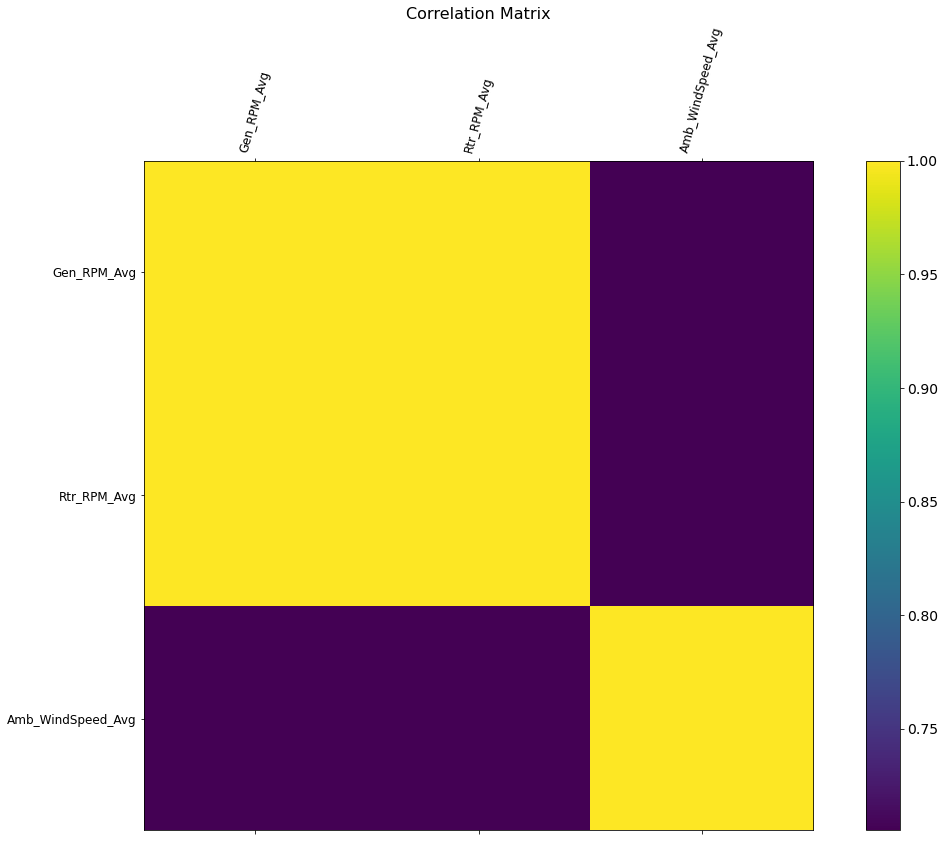

In [27]:
df_corr = df.iloc[:][date_start : date_end]

f = plt.figure(figsize=(19, 12))
plt.matshow(df_corr.corr(), fignum=f.number)
plt.xticks(range(df_corr.select_dtypes(['number']).shape[1]), df_corr.select_dtypes(['number']).columns, fontsize=12, rotation=75)
plt.yticks(range(df_corr.select_dtypes(['number']).shape[1]), df_corr.select_dtypes(['number']).columns, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [28]:
df_corr.corr()

Gen_RPM_Avg  Rtr_RPM_Avg  Amb_WindSpeed_Avg
Gen_RPM_Avg           1.000000     0.999195           0.706177
Rtr_RPM_Avg           0.999195     1.000000           0.705340
Amb_WindSpeed_Avg     0.706177     0.705340           1.000000

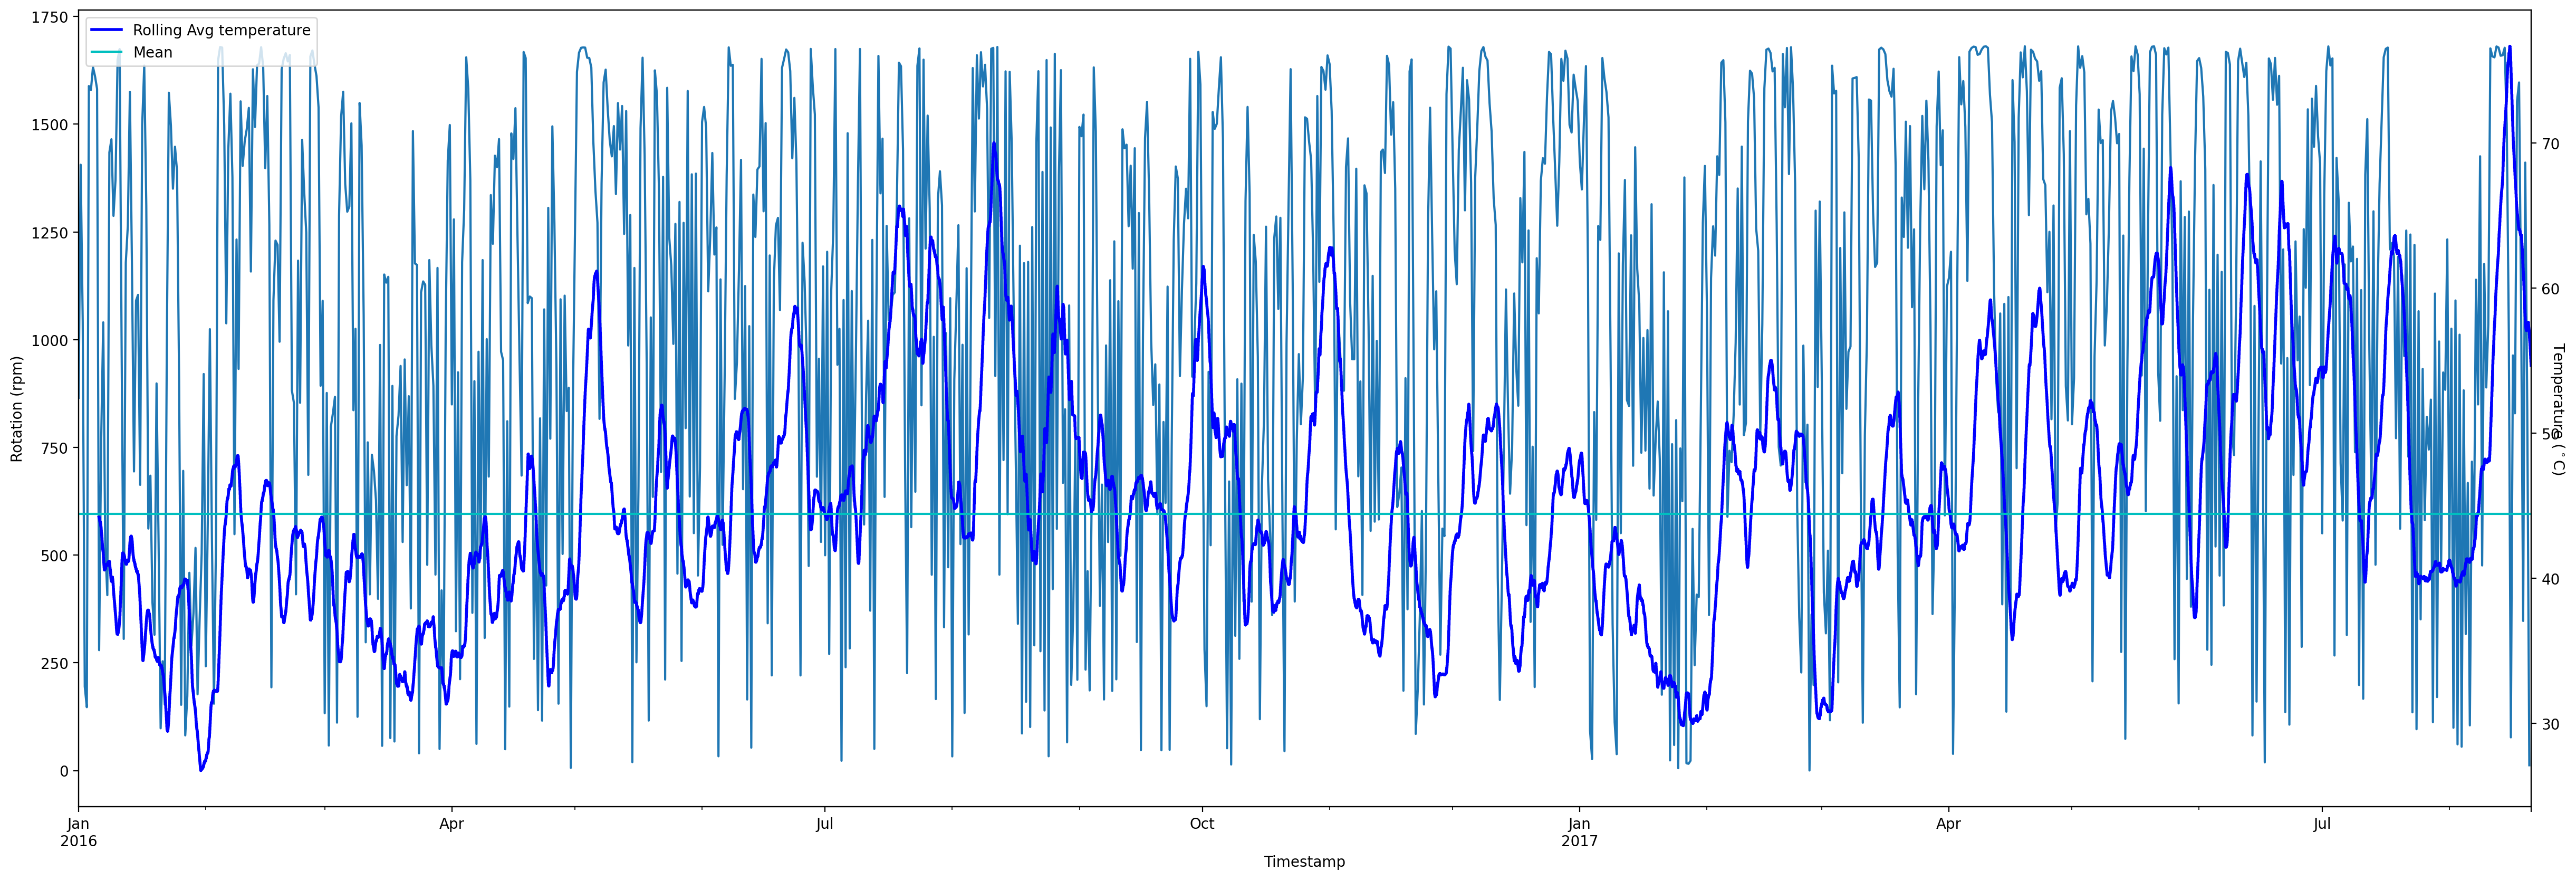

In [95]:
span = 720
variable_1 = 3
variable_2 = 5
variable_3 = 5
variable_1_unit = 'Rotation (rpm)'
variable_2_unit = 'Temperature ($^\circ$C)'
freq = '12H'

# Select time interval to plot
df_1 = df[variables.get(variable_1)][ : date_end ]
df_2 = df[variables.get(variable_2)][ : date_end ]

# Resample
df_1 = df_1.resample(freq).mean()

# Create moving average
ra = df_2.rolling(span).mean()

# Define size of plot and styles etc.
plt.figure(figsize=(30, 10), dpi=200)
df_1.plot(label=variables.get(variable_1), ylabel=variable_1_unit)
ra.plot(secondary_y=True, style='b', label='Rolling Avg temperature', linewidth=2.0)
#ax.right_ax.set_ylabel()
plt.ylabel(variable_2_unit, fontsize=10, rotation=-90)
    
plt.axhline(y=df[variables.get(variable_2)].mean(), color='c', label='Mean')

plt.legend()
plt.show()

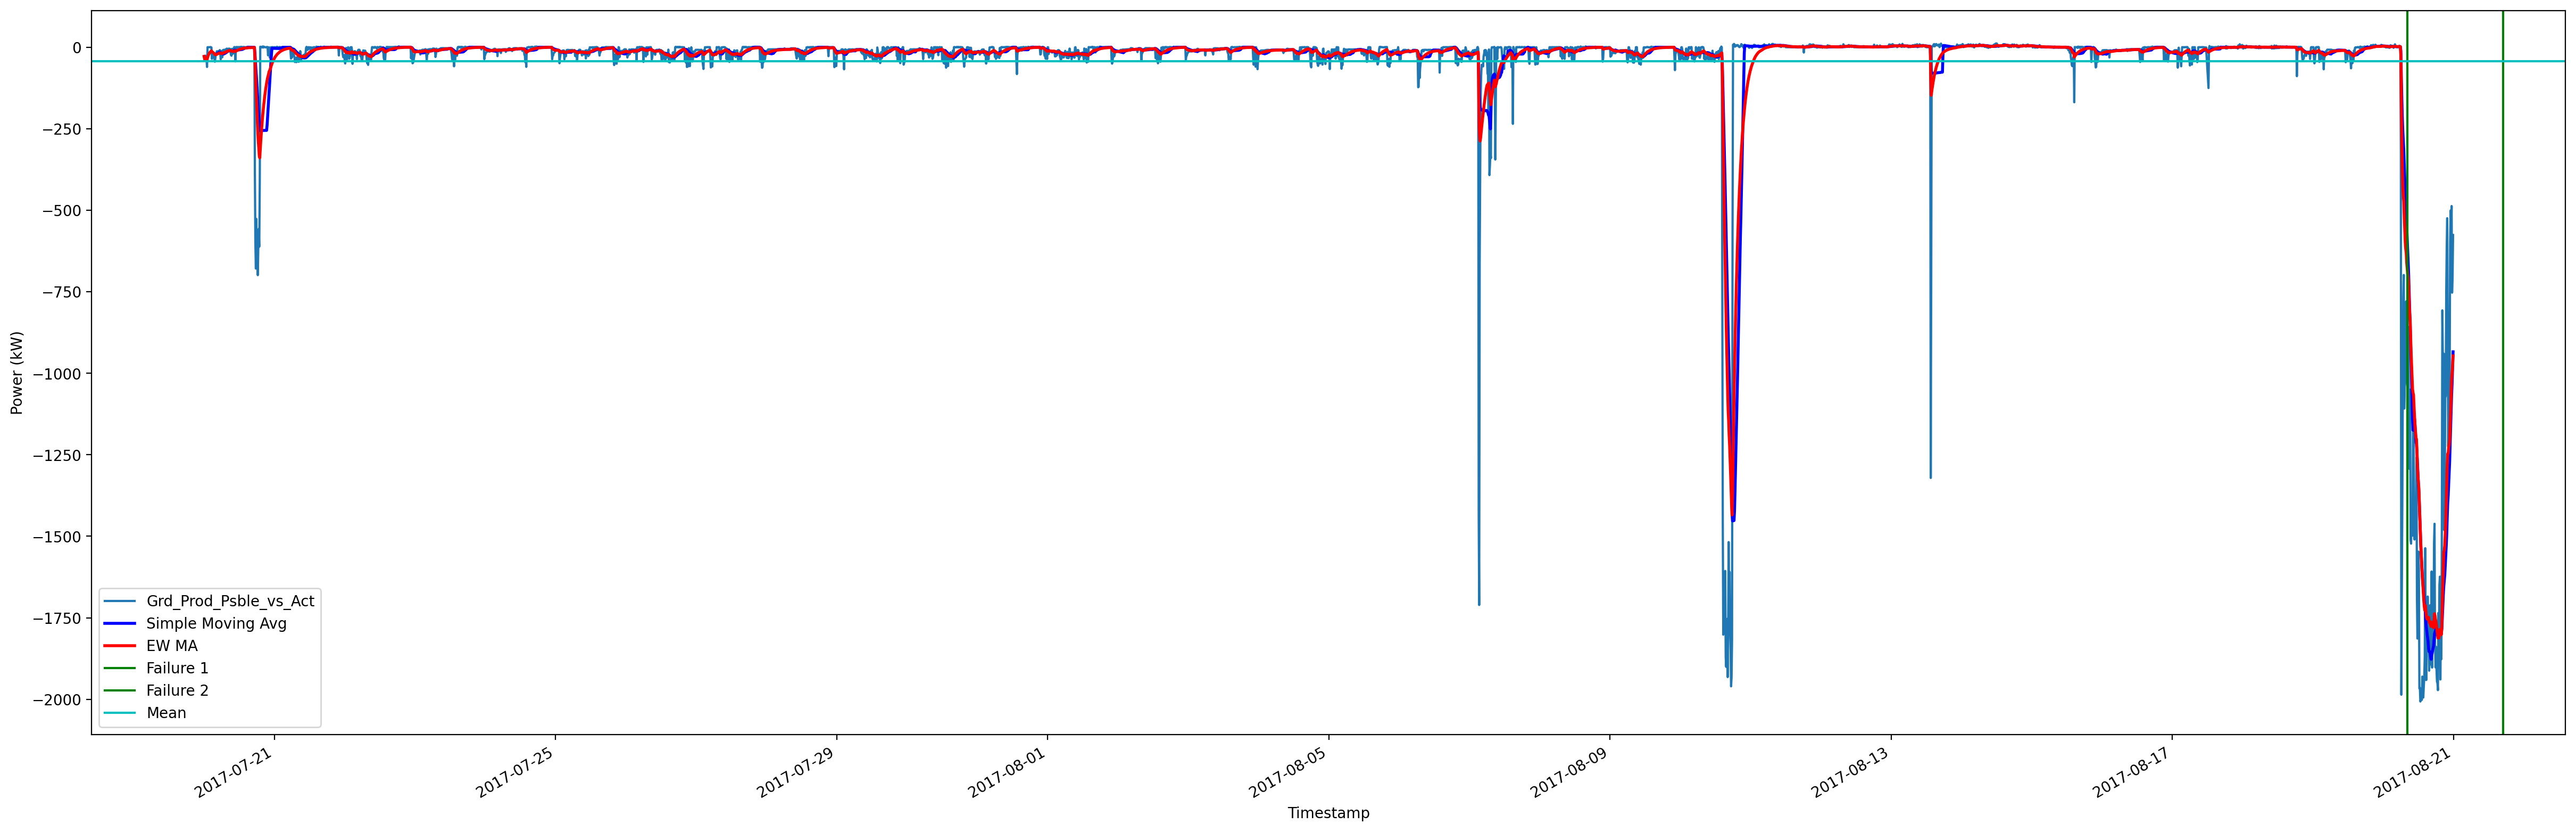

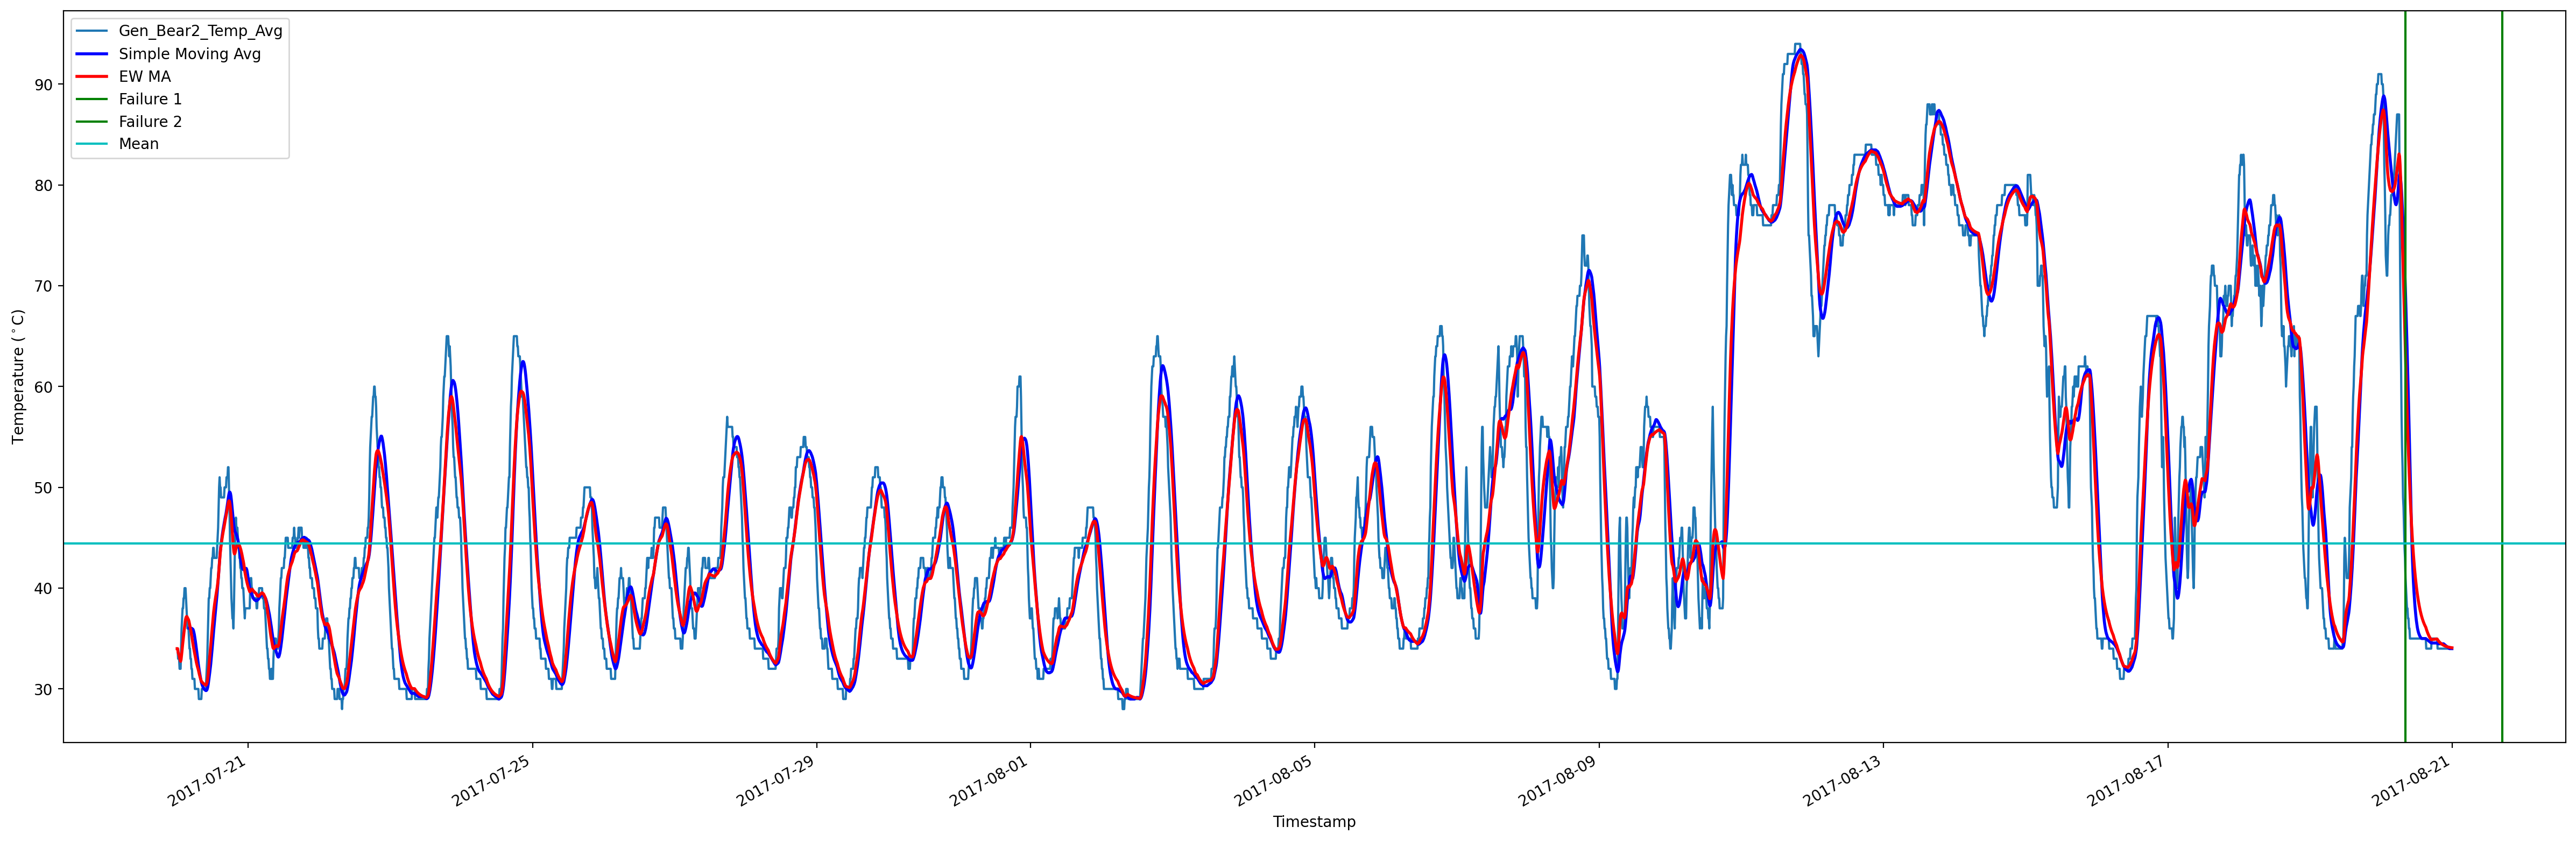

In [162]:
span = 25
variable_1 = 27
variable_2 = 5
variable_1_unit = 'Power (kW)'
variable_2_unit = 'Temperature ($^\circ$C)'
freq = 'W'

## First plot

# Select time interval to plot
df_Psble_vs_Act = df[variables.get(variable_1)][date_start : date_end]

# Resmaple
#df_Psble_vs_Act = df_Psble_vs_Act.resample(freq).mean()

# Create moving average
ma = df_Psble_vs_Act.rolling(span).mean()

# Create exponentially weighted moving average
ewma = df_Psble_vs_Act.ewm(span=span).mean()

# Define size of plot and styles etc.
plt.figure(figsize=(30, 10), dpi=200)
df_Psble_vs_Act.plot(label=variables.get(variable_1), ylabel=variable_1_unit)
ma.plot(style='b', label='Simple Moving Avg', linewidth=2.0)
ewma.plot(style='r', label='EW MA', linewidth=2.0)

# Create vertical lines at times of failure
n = 1
for failure in time_of_failure:
    plt.axvline(x=failure, color='g', label='Failure ' + str(n))
    n += 1
    
# Add upper and lower limits based on std
upper_limit = df[variables.get(variable_1)].mean() + 3 * df[variables.get(variable_1)].std()
lower_limit = df[variables.get(variable_1)].mean() - 3 * df[variables.get(variable_1)].std()
#plt.axhline(y=upper_limit, color='m', label='Upper limit')
#plt.axhline(y=lower_limit, color='m', label='Lower limit')
plt.axhline(y=df[variables.get(variable_1)].mean(), color='c', label='Mean')

plt.legend()


## Second plot

# Select time interval to plot
df_bear2 = df[variables.get(variable_2)][date_start : date_end]

# Resmaple
#df_bear2 = df_bear2.resample(freq).mean()

# Create moving average
ma = df_bear2.rolling(span).mean()

# Create exponentially weighted moving average
ewma = df_bear2.ewm(span=span).mean()

# Define size of plot and styles etc.
plt.figure(figsize=(30, 10), dpi=200)
df_bear2.plot(label=variables.get(variable_2), ylabel=variable_2_unit)
ma.plot(style='b', label='Simple Moving Avg', linewidth=2.0)
ewma.plot(style='r', label='EW MA', linewidth=2.0)

# Create vertical lines at times of failure
n = 1
for failure in time_of_failure:
    plt.axvline(x=failure, color='g', label='Failure ' + str(n))
    n += 1

# Add upper and lower limits based on std
upper_limit = df[variables.get(variable_2)].mean() + 3 * df[variables.get(variable_2)].std()
lower_limit = df[variables.get(variable_2)].mean() - 3 * df[variables.get(variable_2)].std()
#plt.axhline(y=upper_limit, color='m', label='Upper limit')
#plt.axhline(y=lower_limit, color='m', label='Lower limit')
plt.axhline(y=df[variables.get(variable_2)].mean(), color='c', label='Mean')

plt.legend()
plt.show()

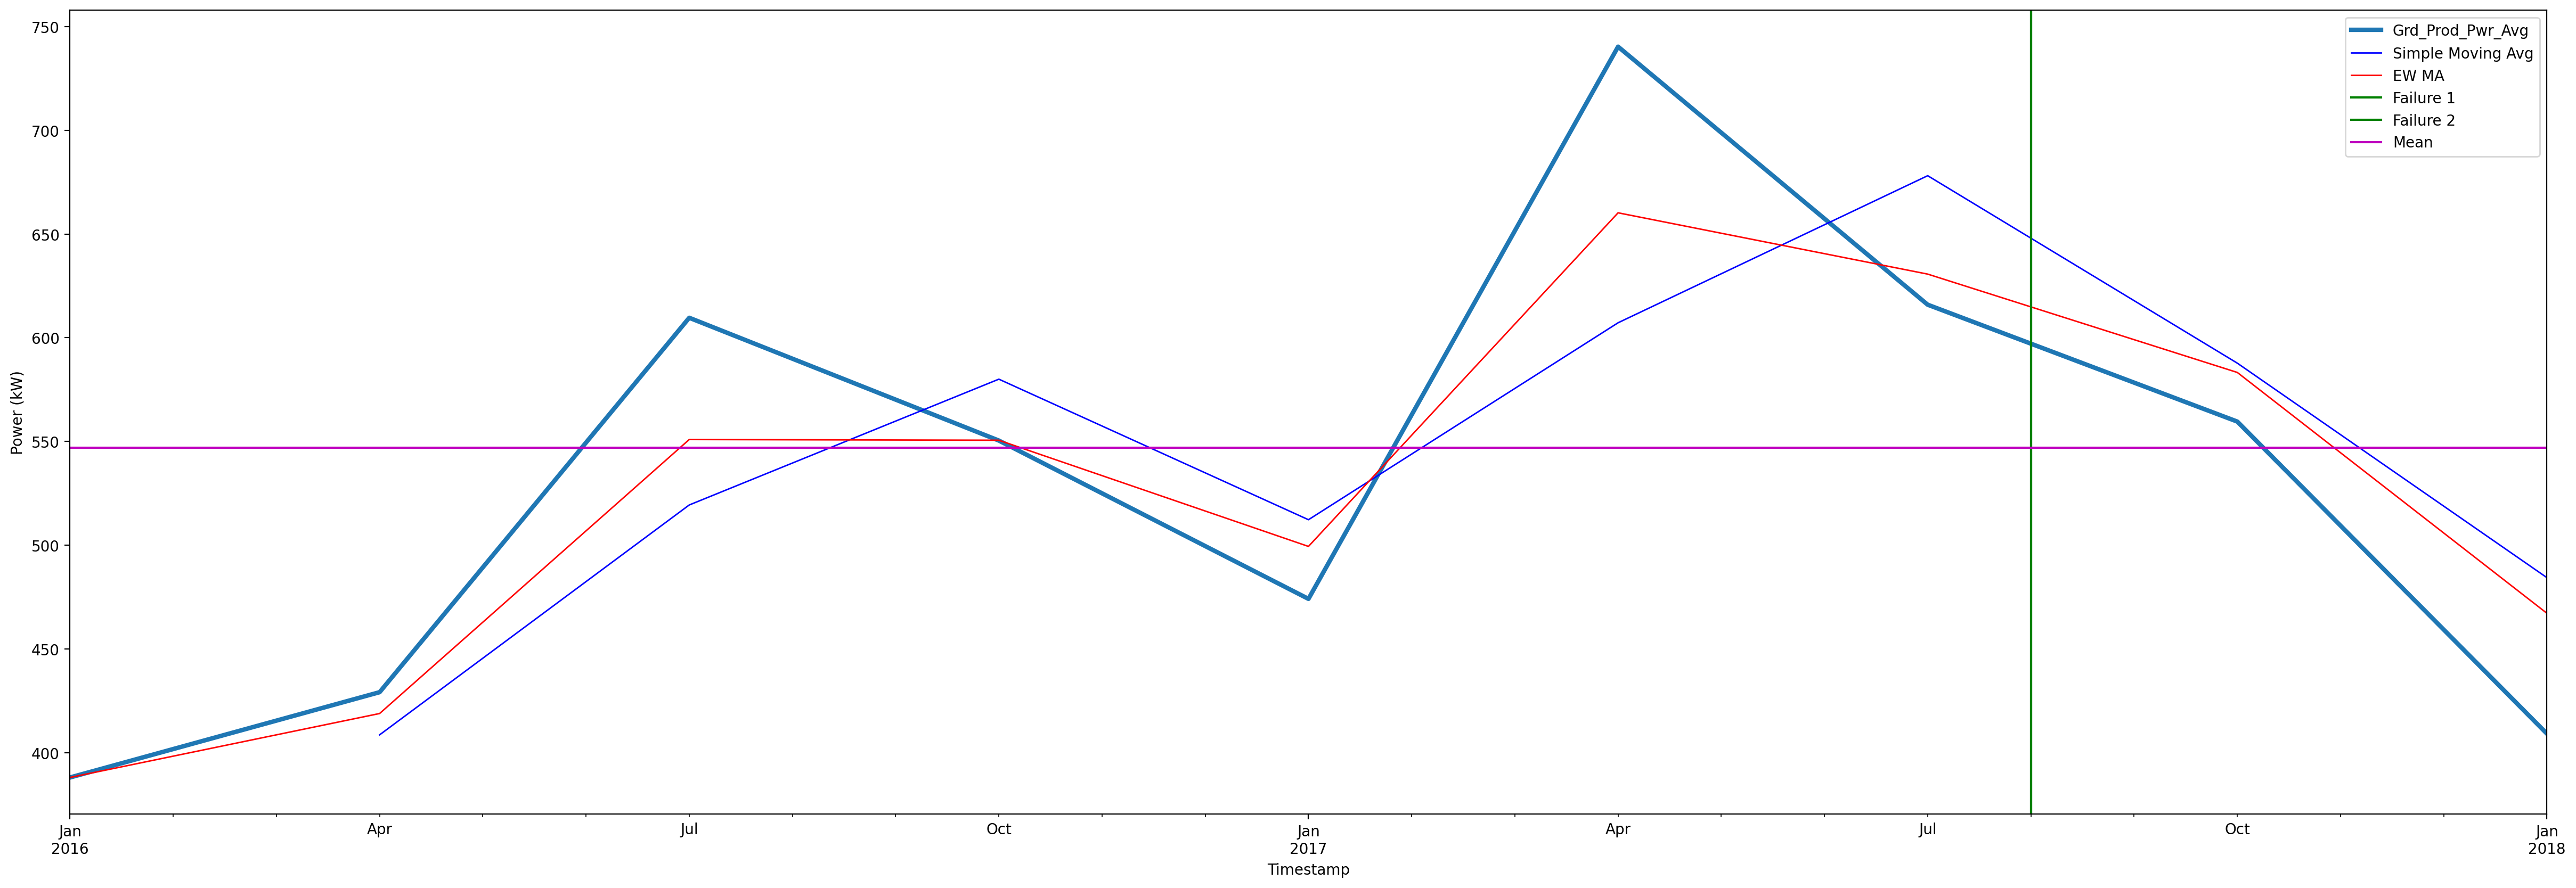

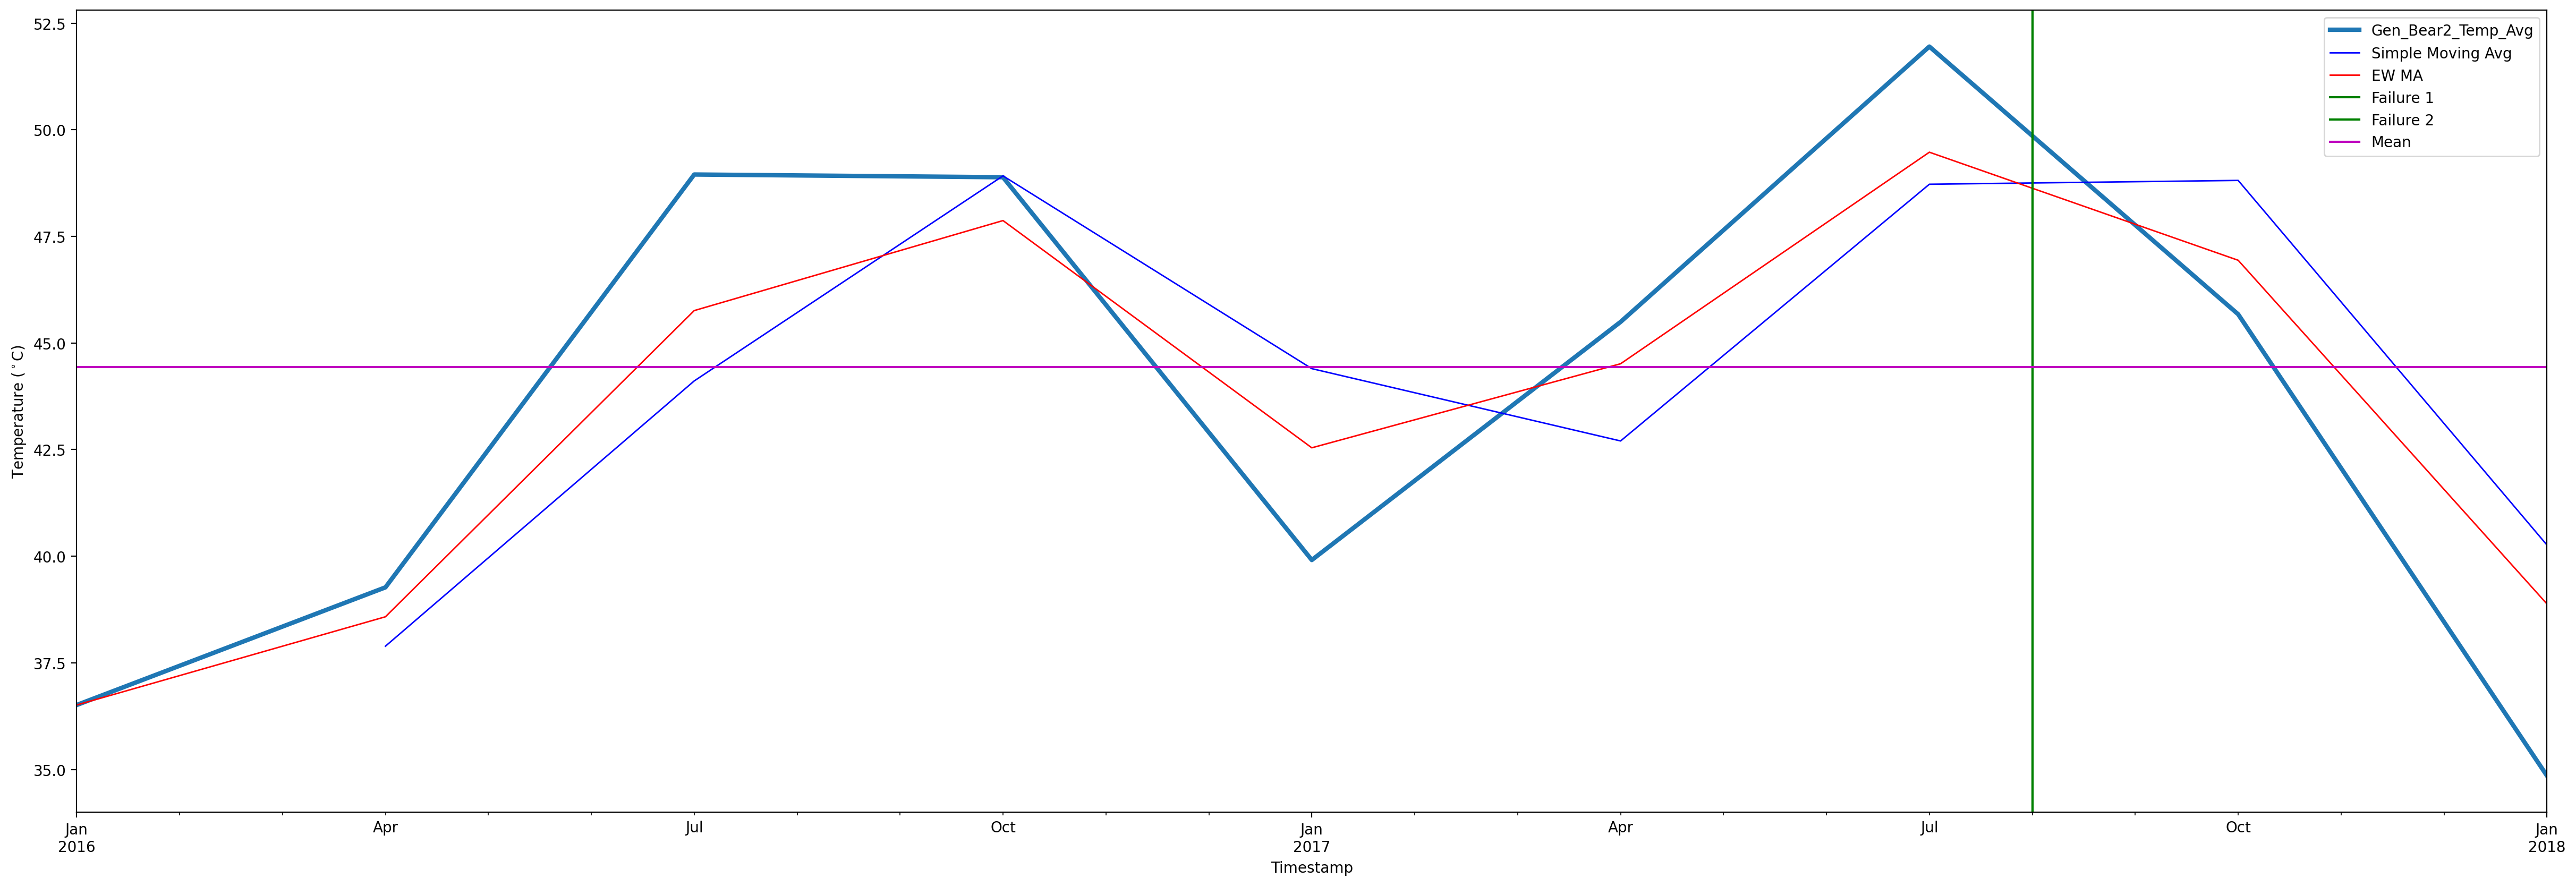

In [44]:
span = 2
variable_1 = 6
variable_2 = 5
variable_1_unit = 'Power (kW)'
variable_2_unit = 'Temperature ($^\circ$C)'
freq = '3M'

# Select time interval to plot
df_Psble_vs_Act = df[variables.get(variable_1)][:]

# Resmaple
df_Psble_vs_Act = df_Psble_vs_Act.resample(freq).mean()

# Create moving average
ma = df_Psble_vs_Act.rolling(span).mean()

# Create exponentially weighted moving average
ewma = df_Psble_vs_Act.ewm(span=span).mean()

# Define size of plot and styles etc.
plt.figure(figsize=(30, 10), dpi=200)
df_Psble_vs_Act.plot(label=variables.get(variable_1), ylabel=variable_1_unit, linewidth=3.0)
ma.plot(style='b', label='Simple Moving Avg', linewidth=1.0)
ewma.plot(style='r', label='EW MA', linewidth=1.0)

# Create vertical lines at times of failure
n = 1
for failure in time_of_failure:
    plt.axvline(x=failure, color='g', label='Failure ' + str(n))
    n += 1

# Add upper and lower limits based on std
upper_limit = df[variables.get(variable_1)].mean() + 3 * df[variables.get(variable_1)].std()
lower_limit = df[variables.get(variable_1)].mean() - 3 * df[variables.get(variable_1)].std()
#plt.axhline(y=upper_limit, color='m', label='Upper limit')
#plt.axhline(y=lower_limit, color='m', label='Lower limit')
plt.axhline(y=df[variables.get(variable_1)].mean(), color='m', label='Mean')

plt.legend()

# Select time interval to plot
df_bear2 = df[variables.get(variable_2)][:]

# Resmaple
df_bear2 = df_bear2.resample(freq).mean()

# Create moving average
ma = df_bear2.rolling(span).mean()

# Create exponentially weighted moving average
ewma = df_bear2.ewm(span=span).mean()

# Define size of plot and styles etc.
plt.figure(figsize=(30, 10), dpi=200)
df_bear2.plot(label=variables.get(variable_2), ylabel=variable_2_unit, linewidth=3.0)
ma.plot(style='b', label='Simple Moving Avg', linewidth=1.0)
ewma.plot(style='r', label='EW MA', linewidth=1.0)

# Create vertical lines at times of failure
n = 1
for failure in time_of_failure:
    plt.axvline(x=failure, color='g', label='Failure ' + str(n))
    n += 1
    
# Add upper and lower limits based on std
upper_limit = df[variables.get(variable_2)].mean() + 3 * df[variables.get(variable_2)].std()
lower_limit = df[variables.get(variable_2)].mean() - 3 * df[variables.get(variable_2)].std()
#plt.axhline(y=upper_limit, color='m', label='Upper limit')
#plt.axhline(y=lower_limit, color='m', label='Lower limit')
plt.axhline(y=df[variables.get(variable_2)].mean(), color='m', label='Mean')

plt.legend()
plt.show()

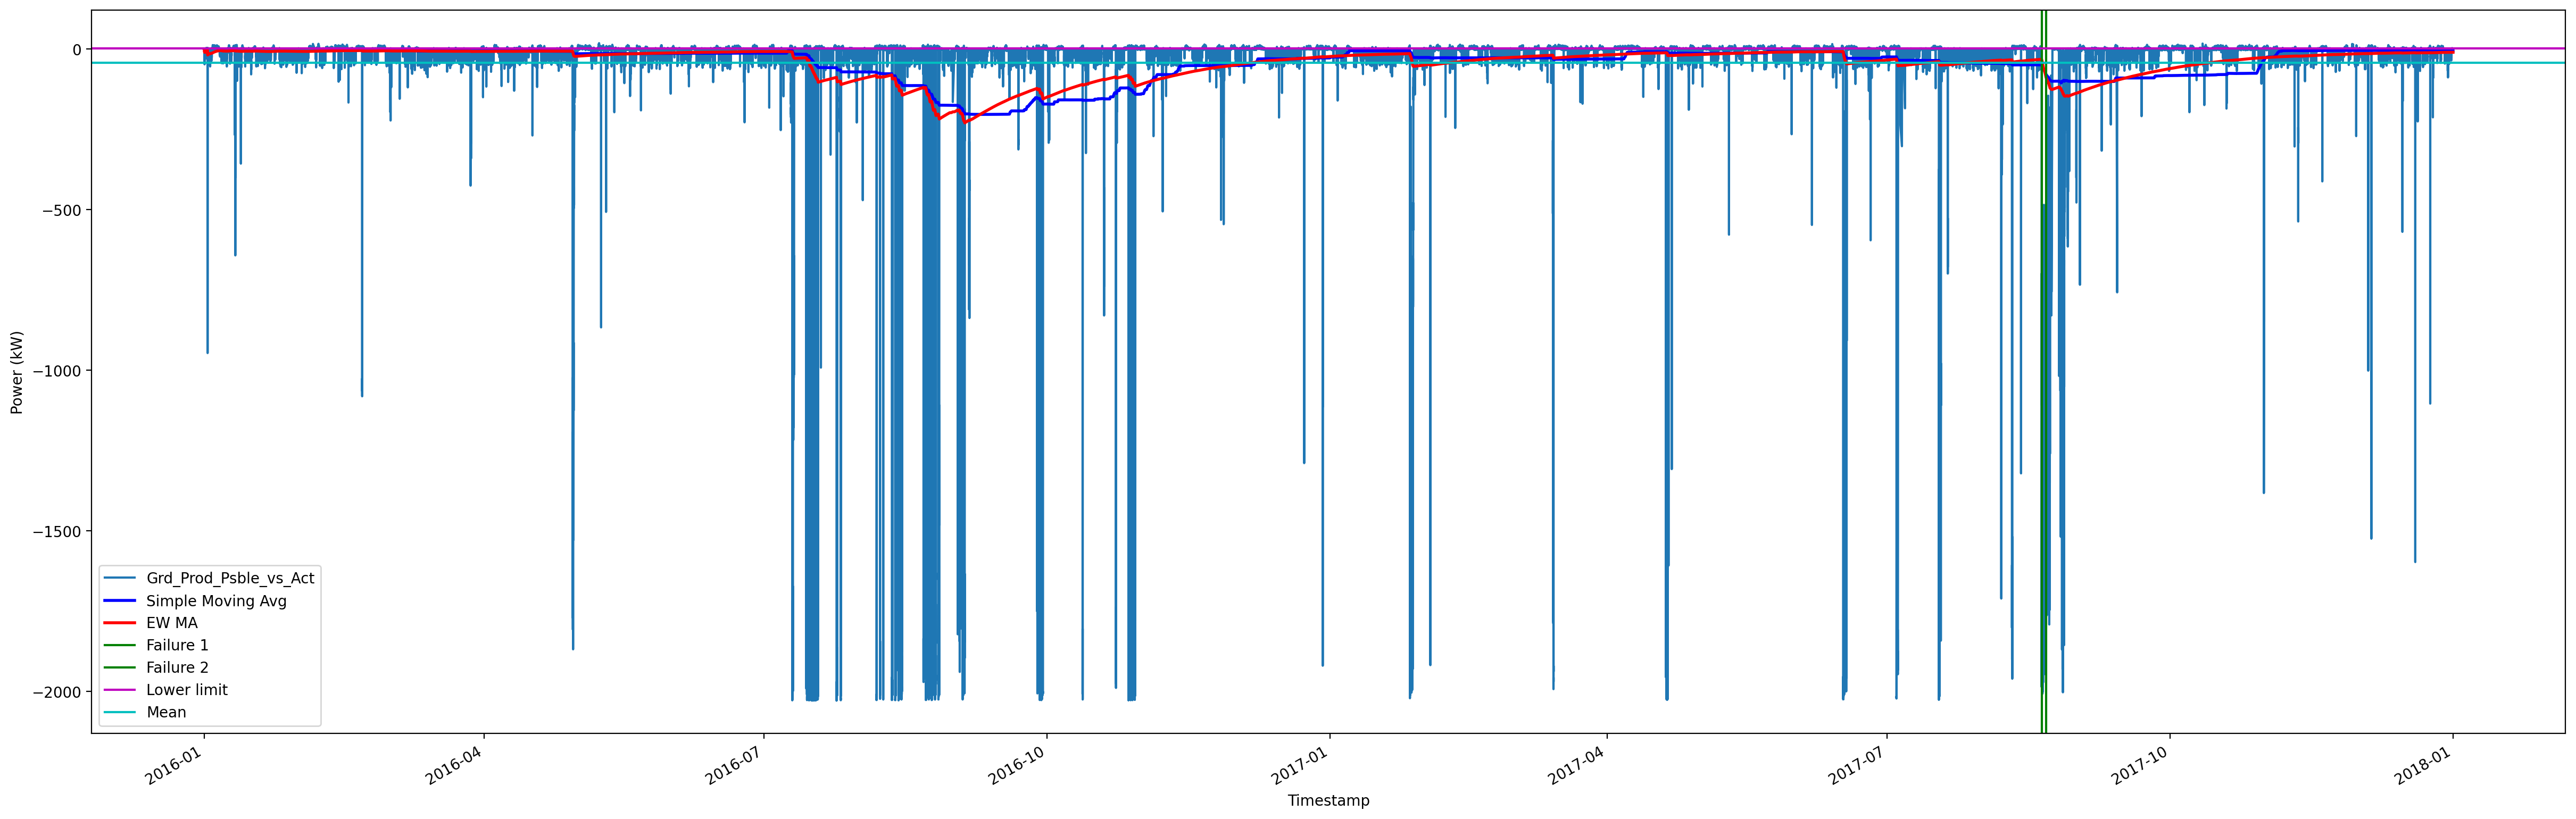

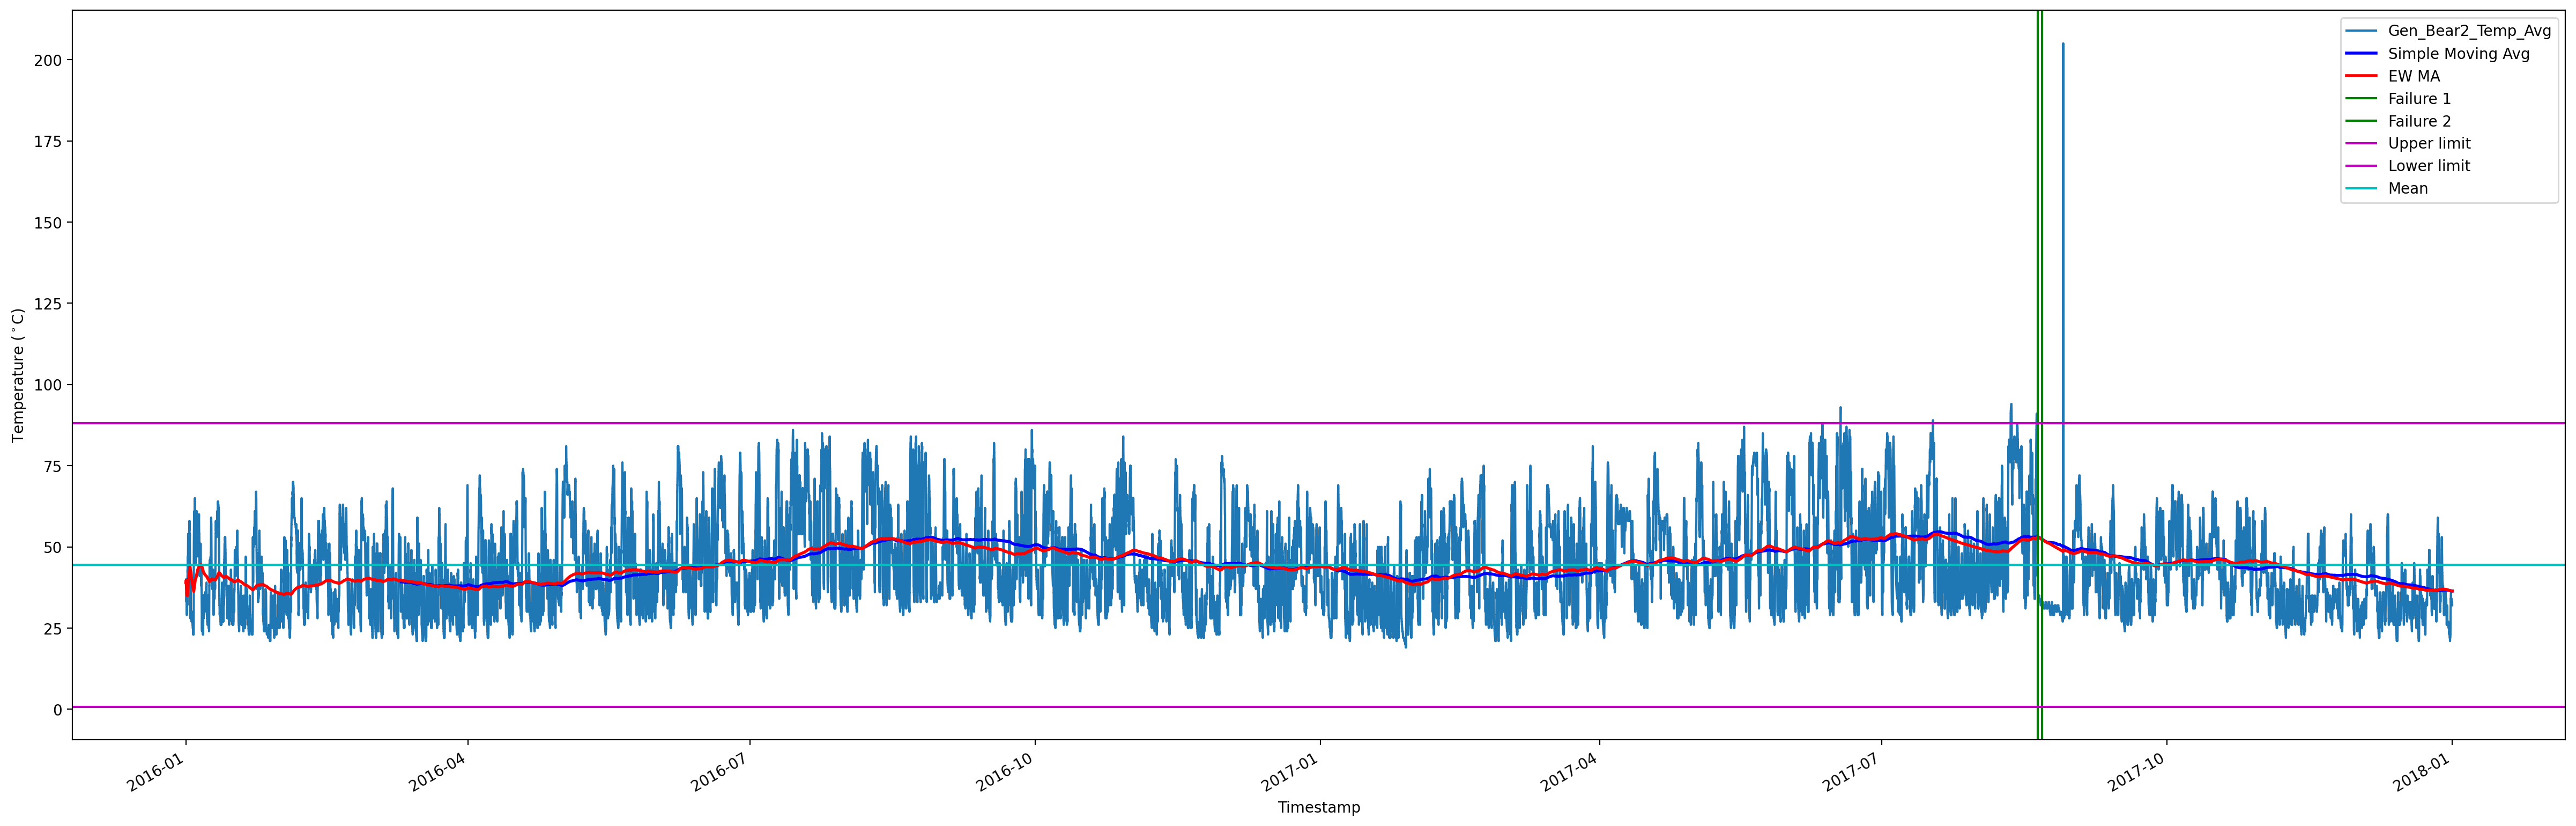

In [55]:
span = 10000
variable_1 = 9
variable_2 = 5
variable_1_unit = 'Power (kW)'
variable_2_unit = 'Temperature ($^\circ$C)'
freq = '12H'
date_start = None
date_end = None

## First plot

# Select time interval to plot
df_Psble_vs_Act = df[variables.get(variable_1)][date_start : date_end]

# Resmaple
#df_Psble_vs_Act = df_Psble_vs_Act.resample(freq).mean()

# Create moving average
ma = df_Psble_vs_Act.rolling(span).mean()

# Create exponentially weighted moving average
ewma = df_Psble_vs_Act.ewm(span=span).mean()

# Define size of plot and styles etc.
plt.figure(figsize=(30, 10), dpi=200)
df_Psble_vs_Act.plot(label=variables.get(variable_1), ylabel=variable_1_unit)
ma.plot(style='b', label='Simple Moving Avg', linewidth=2.0)
ewma.plot(style='r', label='EW MA', linewidth=2.0)

# Create vertical lines at times of failure
n = 1
for failure in time_of_failure:
    plt.axvline(x=failure, color='g', label='Failure ' + str(n))
    n += 1
    
# Add upper and lower limits based on std
#upper_limit = df[variables.get(variable_1)].mean() + 3 * df[variables.get(variable_1)].std()
#lower_limit = df[variables.get(variable_1)].mean() - 3 * df[variables.get(variable_1)].std()
#plt.axhline(y=upper_limit, color='m', label='Upper limit')
plt.axhline(y=lower_limit, color='m', label='Lower limit')
plt.axhline(y=df[variables.get(variable_1)].mean(), color='c', label='Mean')

plt.legend()


## Second plot

# Select time interval to plot
df_bear2 = df[variables.get(variable_2)][date_start : date_end]

# Resmaple
#df_bear2 = df_bear2.resample(freq).mean()

# Create moving average
ma = df_bear2.rolling(span).mean()

# Create exponentially weighted moving average
ewma = df_bear2.ewm(span=span).mean()

# Define size of plot and styles etc.
plt.figure(figsize=(30, 10), dpi=200)
df_bear2.plot(label=variables.get(variable_2), ylabel=variable_2_unit)
ma.plot(style='b', label='Simple Moving Avg', linewidth=2.0)
ewma.plot(style='r', label='EW MA', linewidth=2.0)

# Create vertical lines at times of failure
n = 1
for failure in time_of_failure:
    plt.axvline(x=failure, color='g', label='Failure ' + str(n))
    n += 1

# Add upper and lower limits based on std
upper_limit = df[variables.get(variable_2)].mean() + 3 * df[variables.get(variable_2)].std()
lower_limit = df[variables.get(variable_2)].mean() - 3 * df[variables.get(variable_2)].std()
plt.axhline(y=upper_limit, color='m', label='Upper limit')
plt.axhline(y=lower_limit, color='m', label='Lower limit')
plt.axhline(y=df[variables.get(variable_2)].mean(), color='c', label='Mean')

plt.legend()
plt.show()

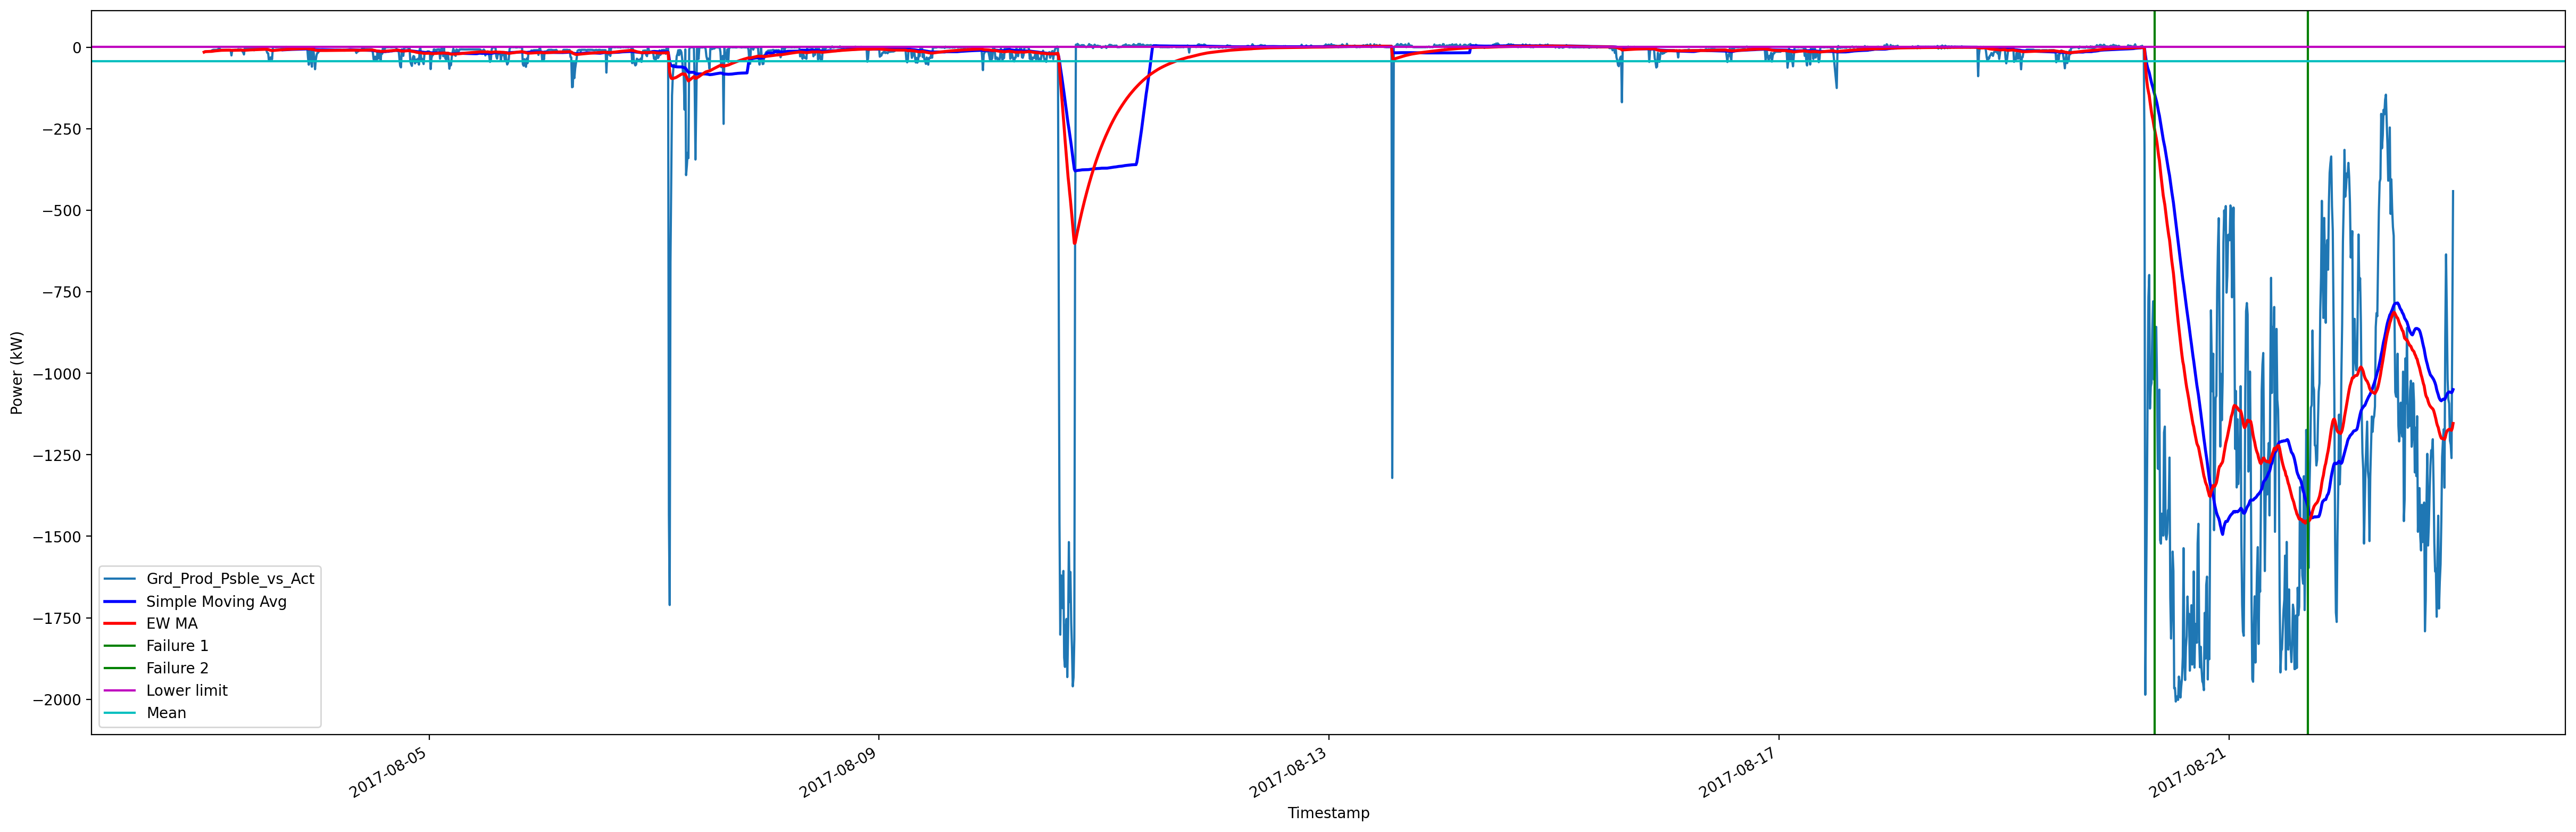

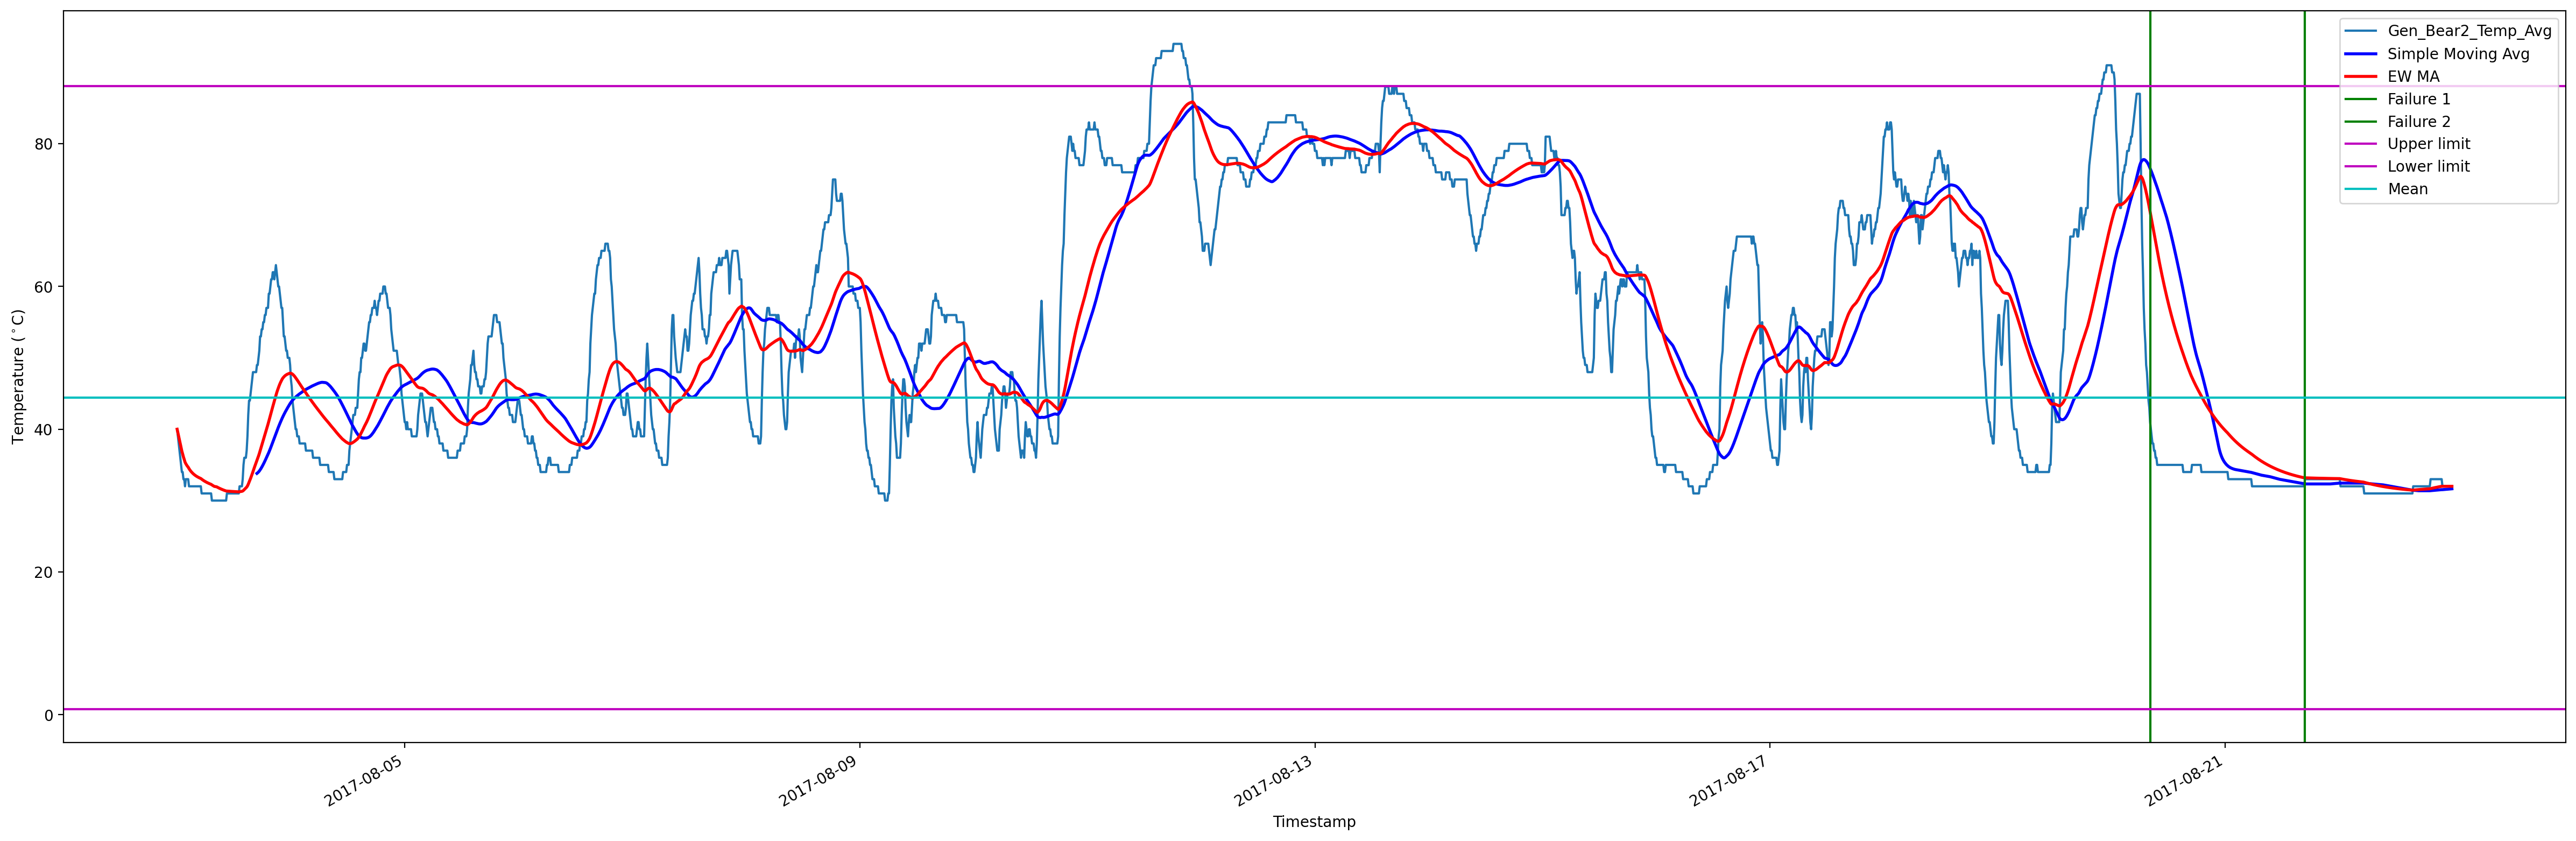

In [51]:
span = 100
variable_1 = 9
variable_2 = 5
variable_1_unit = 'Power (kW)'
variable_2_unit = 'Temperature ($^\circ$C)'
freq = '12H'
date_start = '2017-08-03'
date_end = '2017-08-22'

## First plot

# Select time interval to plot
df_Psble_vs_Act = df[variables.get(variable_1)][date_start : date_end]

# Resmaple
#df_Psble_vs_Act = df_Psble_vs_Act.resample(freq).mean()

# Create moving average
ma = df_Psble_vs_Act.rolling(span).mean()

# Create exponentially weighted moving average
ewma = df_Psble_vs_Act.ewm(span=span).mean()

# Define size of plot and styles etc.
plt.figure(figsize=(30, 10), dpi=200)
df_Psble_vs_Act.plot(label=variables.get(variable_1), ylabel=variable_1_unit)
ma.plot(style='b', label='Simple Moving Avg', linewidth=2.0)
ewma.plot(style='r', label='EW MA', linewidth=2.0)

# Create vertical lines at times of failure
n = 1
for failure in time_of_failure:
    plt.axvline(x=failure, color='g', label='Failure ' + str(n))
    n += 1
    
# Add upper and lower limits based on std
#upper_limit = df[variables.get(variable_1)].mean() + 3 * df[variables.get(variable_1)].std()
#lower_limit = df[variables.get(variable_1)].mean() - 3 * df[variables.get(variable_1)].std()
#plt.axhline(y=upper_limit, color='m', label='Upper limit')
plt.axhline(y=lower_limit, color='m', label='Lower limit')
plt.axhline(y=df[variables.get(variable_1)].mean(), color='c', label='Mean')

plt.legend()


## Second plot

# Select time interval to plot
df_bear2 = df[variables.get(variable_2)][date_start : date_end]

# Resmaple
#df_bear2 = df_bear2.resample(freq).mean()

# Create moving average
ma = df_bear2.rolling(span).mean()

# Create exponentially weighted moving average
ewma = df_bear2.ewm(span=span).mean()

# Define size of plot and styles etc.
plt.figure(figsize=(30, 10), dpi=200)
df_bear2.plot(label=variables.get(variable_2), ylabel=variable_2_unit)
ma.plot(style='b', label='Simple Moving Avg', linewidth=2.0)
ewma.plot(style='r', label='EW MA', linewidth=2.0)

# Create vertical lines at times of failure
n = 1
for failure in time_of_failure:
    plt.axvline(x=failure, color='g', label='Failure ' + str(n))
    n += 1

# Add upper and lower limits based on std
upper_limit = df[variables.get(variable_2)].mean() + 3 * df[variables.get(variable_2)].std()
lower_limit = df[variables.get(variable_2)].mean() - 3 * df[variables.get(variable_2)].std()
plt.axhline(y=upper_limit, color='m', label='Upper limit')
plt.axhline(y=lower_limit, color='m', label='Lower limit')
plt.axhline(y=df[variables.get(variable_2)].mean(), color='c', label='Mean')

plt.legend()
plt.show()

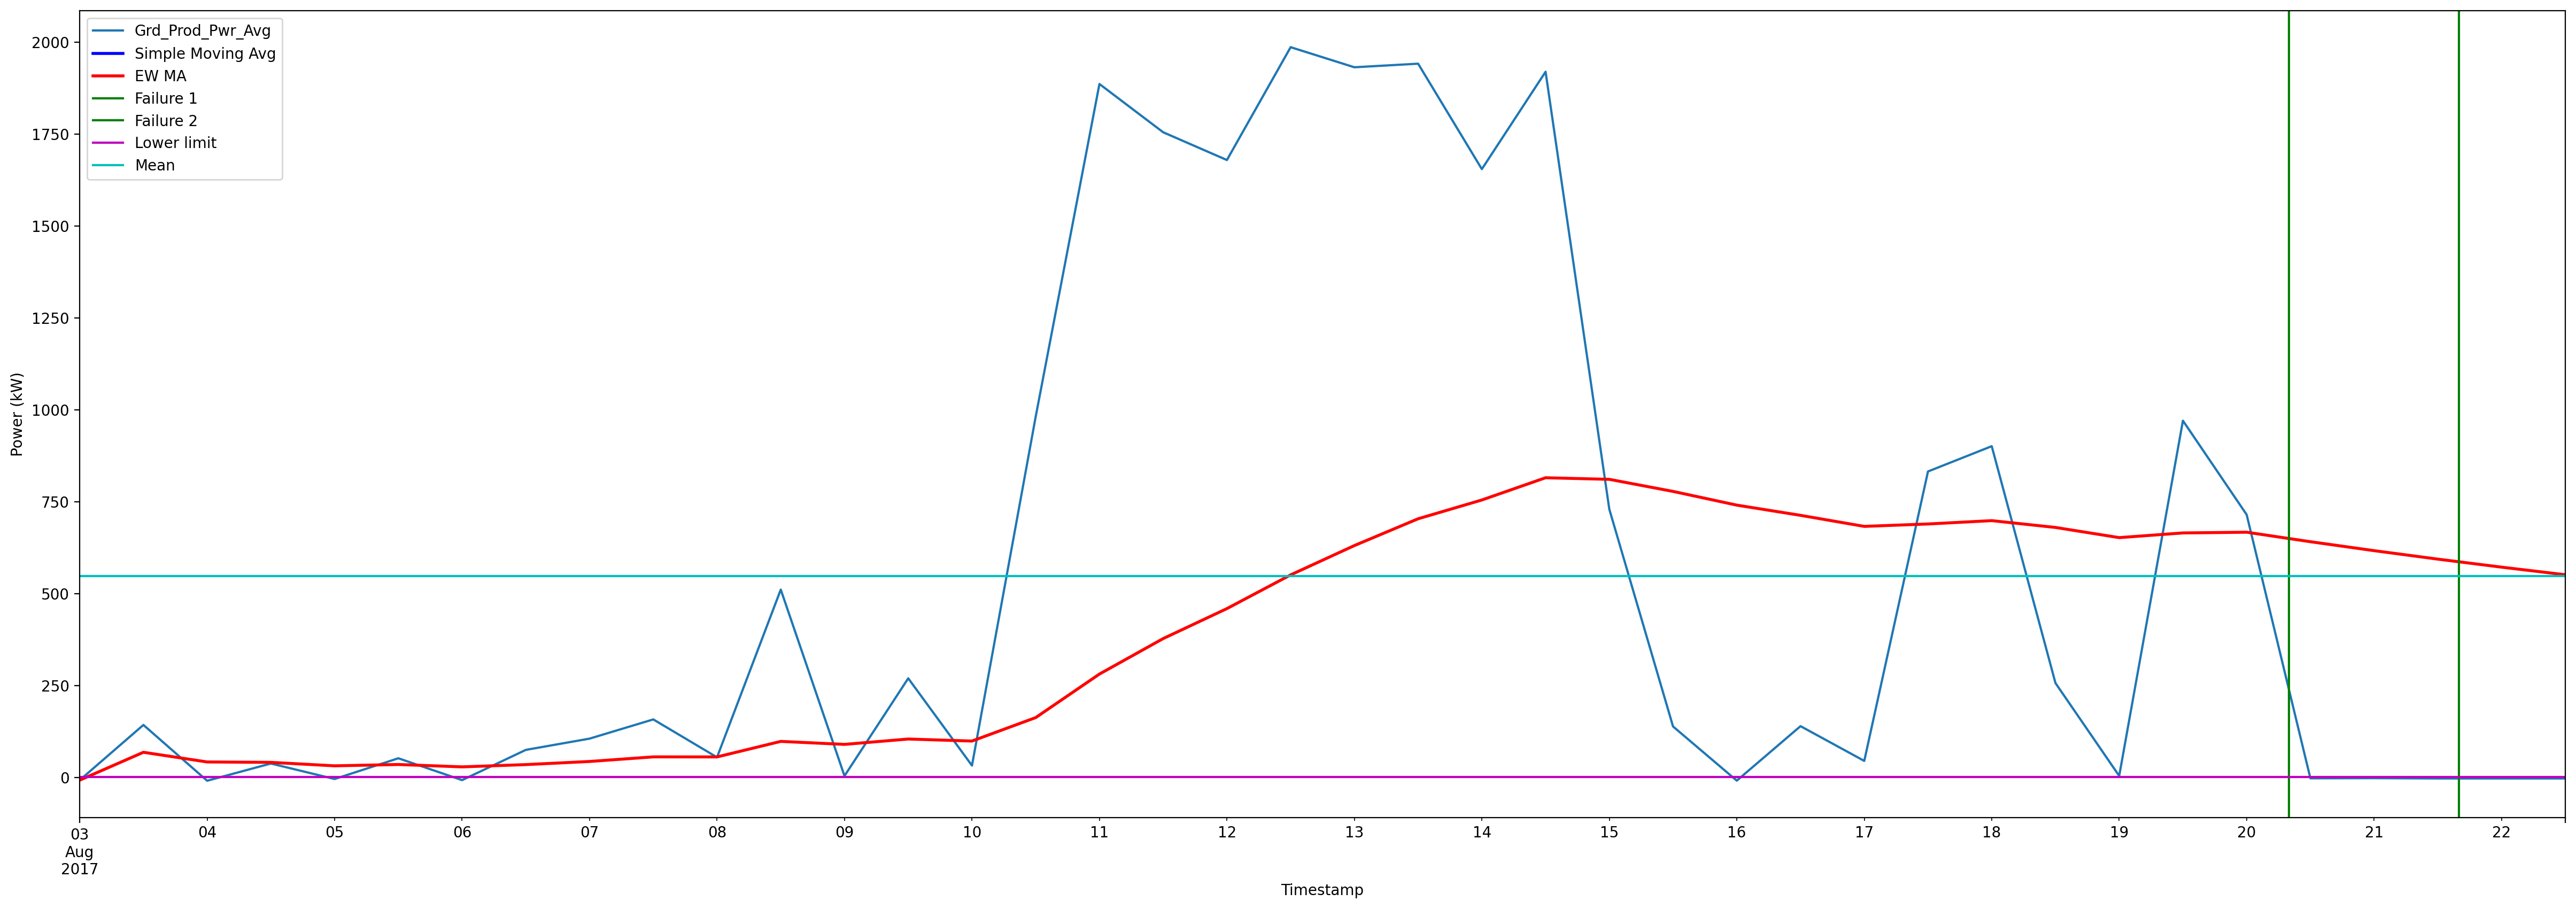

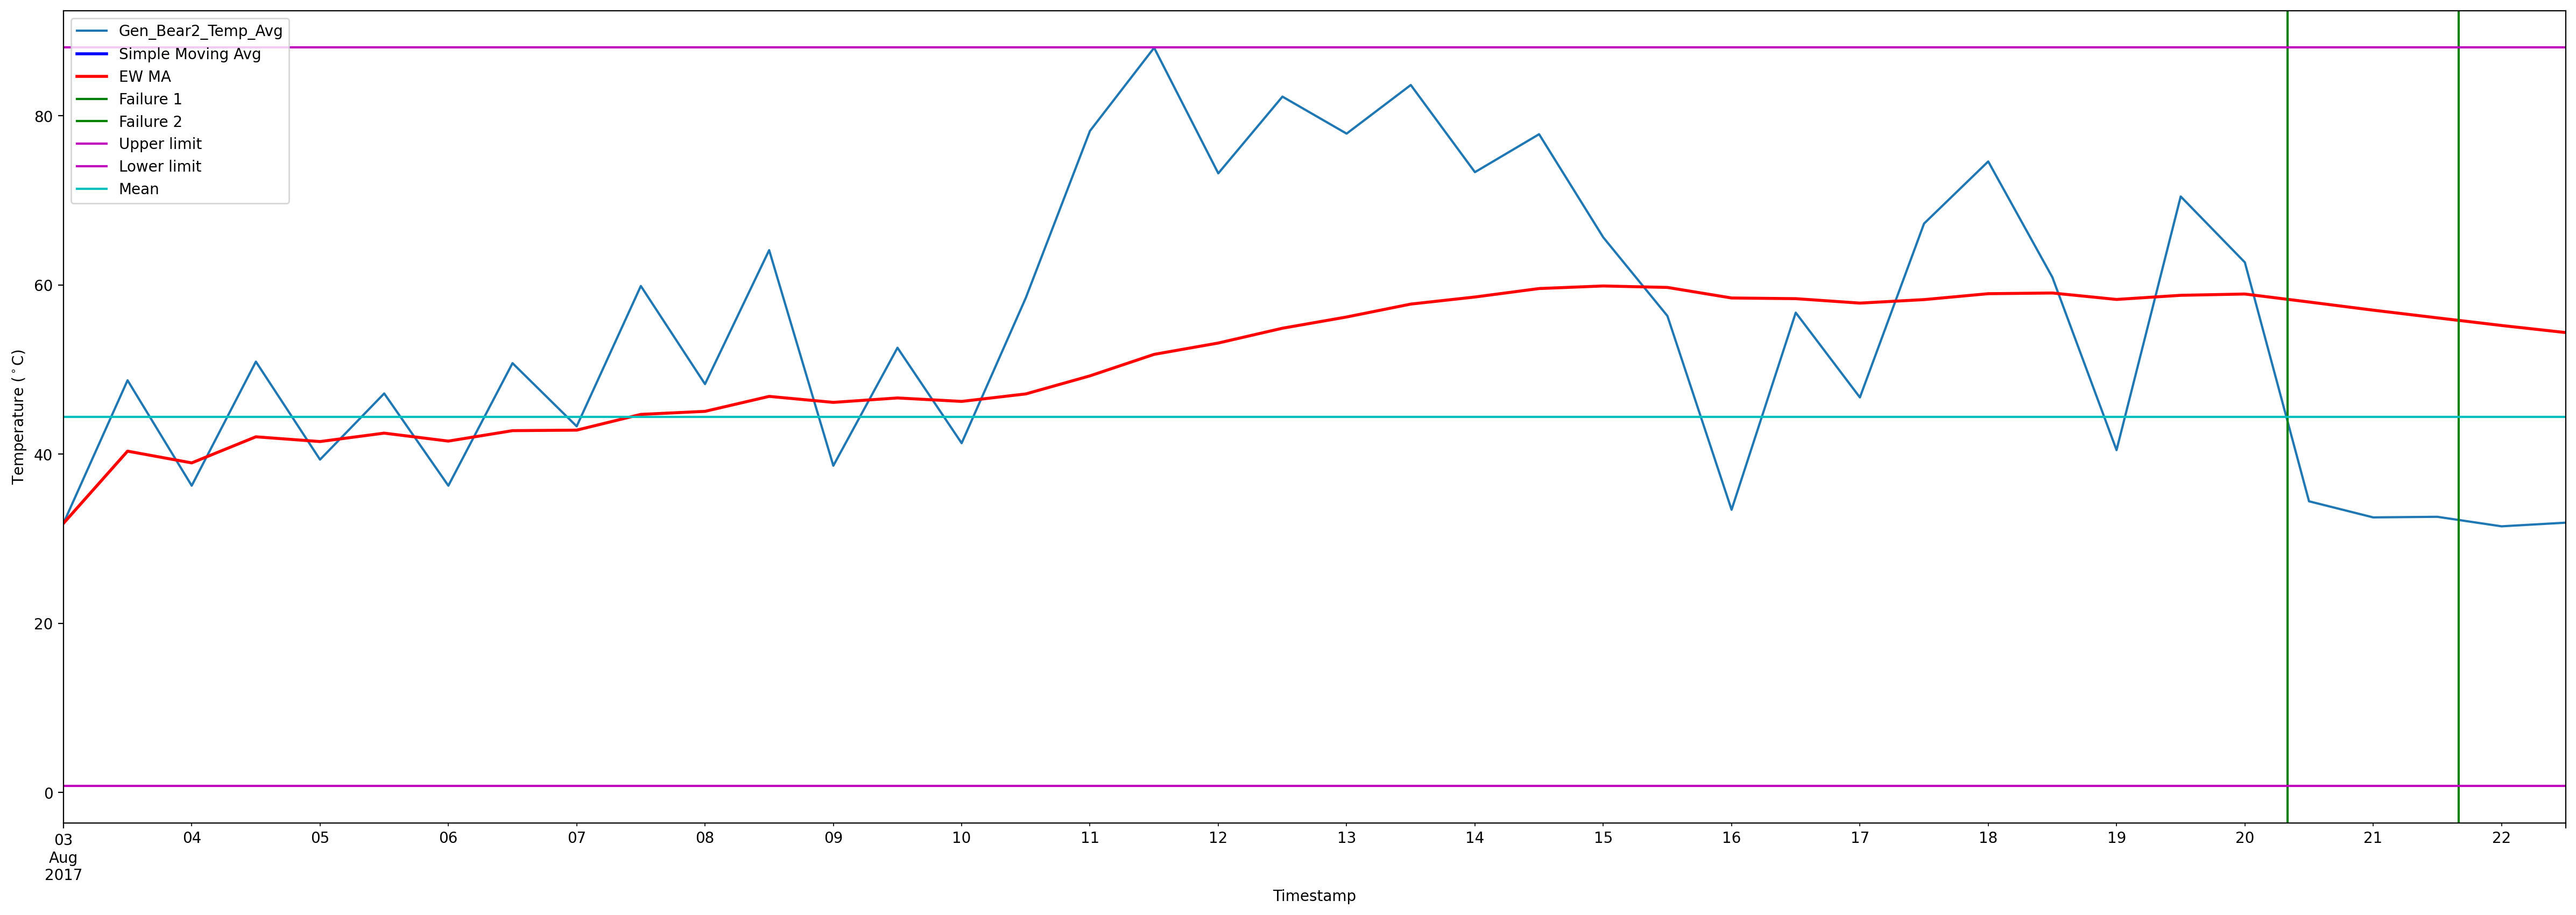

In [49]:
span = 100
variable_1 = 6
variable_2 = 5
variable_1_unit = 'Power (kW)'
variable_2_unit = 'Temperature ($^\circ$C)'
freq = '12H'
date_start = '2017-08-03'
date_end = '2017-08-22'

## First plot

# Select time interval to plot
df_Psble_vs_Act = df[variables.get(variable_1)][date_start : date_end]

# Resmaple
df_Psble_vs_Act = df_Psble_vs_Act.resample(freq).mean()

# Create moving average
ma = df_Psble_vs_Act.rolling(span).mean()

# Create exponentially weighted moving average
ewma = df_Psble_vs_Act.ewm(span=span).mean()

# Define size of plot and styles etc.
plt.figure(figsize=(30, 10), dpi=200)
df_Psble_vs_Act.plot(label=variables.get(variable_1), ylabel=variable_1_unit)
ma.plot(style='b', label='Simple Moving Avg', linewidth=2.0)
ewma.plot(style='r', label='EW MA', linewidth=2.0)

# Create vertical lines at times of failure
n = 1
for failure in time_of_failure:
    plt.axvline(x=failure, color='g', label='Failure ' + str(n))
    n += 1
    
# Add upper and lower limits based on std
#upper_limit = df[variables.get(variable_1)].mean() + 3 * df[variables.get(variable_1)].std()
#lower_limit = df[variables.get(variable_1)].mean() - 3 * df[variables.get(variable_1)].std()
#plt.axhline(y=upper_limit, color='m', label='Upper limit')
plt.axhline(y=lower_limit, color='m', label='Lower limit')
plt.axhline(y=df[variables.get(variable_1)].mean(), color='c', label='Mean')

plt.legend()


## Second plot

# Select time interval to plot
df_bear2 = df[variables.get(variable_2)][date_start : date_end]

# Resmaple
df_bear2 = df_bear2.resample(freq).mean()

# Create moving average
ma = df_bear2.rolling(span).mean()

# Create exponentially weighted moving average
ewma = df_bear2.ewm(span=span).mean()

# Define size of plot and styles etc.
plt.figure(figsize=(30, 10), dpi=200)
df_bear2.plot(label=variables.get(variable_2), ylabel=variable_2_unit)
ma.plot(style='b', label='Simple Moving Avg', linewidth=2.0)
ewma.plot(style='r', label='EW MA', linewidth=2.0)

# Create vertical lines at times of failure
n = 1
for failure in time_of_failure:
    plt.axvline(x=failure, color='g', label='Failure ' + str(n))
    n += 1

# Add upper and lower limits based on std
upper_limit = df[variables.get(variable_2)].mean() + 3 * df[variables.get(variable_2)].std()
lower_limit = df[variables.get(variable_2)].mean() - 3 * df[variables.get(variable_2)].std()
plt.axhline(y=upper_limit, color='m', label='Upper limit')
plt.axhline(y=lower_limit, color='m', label='Lower limit')
plt.axhline(y=df[variables.get(variable_2)].mean(), color='c', label='Mean')

plt.legend()
plt.show()

In [72]:
df = df.iloc[:]['2017-07-20' : '2017-08-20']

In [74]:
df.tail(5)

Turbine_ID  Gen_RPM_Avg  Gen_Bear_Temp_Avg  \
Timestamp                                                        
2017-08-20 23:10:00        T07          5.2               33.0   
2017-08-20 23:20:00        T07          6.7               33.0   
2017-08-20 23:30:00        T07         11.8               33.0   
2017-08-20 23:40:00        T07          8.7               33.0   
2017-08-20 23:50:00        T07          4.2               33.0   

                     Gen_Bear2_Temp_Avg  Grd_Prod_Pwr_Avg  \
Timestamp                                                   
2017-08-20 23:10:00                  34              -1.4   
2017-08-20 23:20:00                  34              -1.4   
2017-08-20 23:30:00                  34              -1.4   
2017-08-20 23:40:00                  34              -1.4   
2017-08-20 23:50:00                  34              -1.4   

                     Grd_Prod_PsblePwr_Avg  Gen_RPM_Max  Grd_Prod_Psble_vs_Act  
Timestamp                                                                       
2017-08-20 23:10:00                  558.9         32.7                 -560.3  
2017-08-20 23:20:00                  485.8         25.4                 -487.2  
2017-08-20 23:30:00                  751.4         43.2                 -752.8  
2017-08-20 23:40:00                  701.2         31.4                 -702.6  
2017-08-20 23:50:00                  574.6         27.0                 -576.0